In [1]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
import torch.optim as optim
from scipy import linalg
import opt1d
os.chdir('/home/baly/projects/sopt_shape')

In [2]:
from lib.library import *
from lib.lib_ot import *
from lib.sliced_opt import *
from lib.lib_shape import *


/home/baly/projects/sopt_shape/lib/lib_shape.py:485: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  beta=vec_mean(T)-vec_mean(scalar*S.dot(rotation))
/home/baly/projects/sopt_shape/lib/lib_shape.py:503: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  beta=vec_mean(T_hat)-vec_mean(scalar*S.dot(rotation))
/home/baly/projects/sopt_shape/lib/lib_shape.py:547: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  beta=vec_mean(T)-vec_mean(scalar*np.dot(S,rotation))


In [ ]:
# our method 1: 
# input, X, Y, N0, n_projetions,
# output Yhat_list

# load data 
i=19
j=2
label='female'
data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
print(label)


#C=X.copy()
#K=600 # # of centers
# our method
#@nb.njit()

method='sopt_Gaussian'
sigma2=0.001
eps=0.001
n_projections=300
middle_point=100
record_index1=np.linspace(0,middle_point,50).astype(np.int64)
record_index2=np.linspace(middle_point,n_projections-1,50).astype(np.int64)
record_index=np.unique(np.concatenate((record_index1,record_index2)))
record_index.sort()


for eta in [0.05,0.10]:
    print('label is %s,method is %s, eta is %0.2f'%(label,method,eta))
    X0=data['X0']
    N0=X0.shape[0]
    X=data['X'+str(eta)]
    Y=data['Y'+str(eta)]

    time_start=time.time()
    Yhat_list,_=sopt_Gaussian_cuda(X,Y,N0,n_projections=n_projections,sigma2=sigma2,eps=eps,record_index=record_index)
    time_end=time.time()
    result={}
    result['Yhat_list']=Yhat_list
    result['time']=time_end-time_start
    torch.save(result,'result/3D_%s/%s_%0.2f.pt'%(label,method,eta))
    print('done')

female
label is female,method is sopt_Gaussian, eta is 0.05


In [7]:
# def main_Gaussian(X,Y,N0,n_projections=1000,sigma2=1e-4, record_index=[0,20,100,200,400,500,700,900]):
#     N1,D=X.shape
#     C=X.copy()
#     Phi=kernel_matrix_Gaussian(C,X,sigma2) 

#     # initlize 
#     R=np.eye(D)    
#     S=1.0 #np.eye(d)
#     beta=vec_mean(Y)-vec_mean(S*X.dot(R)) 
#     alpha=np.zeros((C.shape[0],D))
    
#     #paramlist=[]
#     projections=random_projections(D,n_projections,1)
#     mass_diff=0
#     #b=0
#     b=np.log((N1-N0+1)/1)
#     Lambda=60*np.sum((vec_mean(Y)-vec_mean(X))**2)
#     Y_hat=Phi.dot(alpha)+S*X.dot(R)+beta
#     # make_plot(Y_hat,Y)

#     Domain_org=arange(0,N1)
#     Delta=Lambda/8
#     lower_bound=Lambda/10000
#     L=Domain_org.copy()

#     Yhat_list=list()
#     for (epoch,theta) in enumerate(projections):    
#         # compute correspondence 
#         Y_hat_theta=np.dot(theta,Y_hat.T)
#         Y_theta=np.dot(theta,Y.T)

#         Y_hat_indice=Y_hat_theta.argsort()
#         Y_indice=Y_theta.argsort()
#         Y_hat_s=Y_hat_theta[Y_hat_indice]
#         Y_s=Y_theta[Y_indice]
#         obj,phi,psi,piRow,piCol=solve_opt(Y_hat_s,Y_s,Lambda)
#         L=piRow.copy()
#         L=recover_indice(Y_hat_indice,Y_indice,L)
#         Domain=Domain_org[L>=0]

#         #move selected Y_hat
#         mass=Domain.shape[0]
#         # if Domain.shape[0]>=1:
#         Range=L[L>=0]
#         Y_hat[Domain]+=np.expand_dims(Y_theta[Domain]-Y_hat_theta[Domain],1)*theta

#         # find optimal R,S,beta, conditonal on alpha
#         Y_prime2=Y_hat[Domain]-Phi[Domain].dot(alpha)
#         R,S=recover_rotation(Y_prime2,X[Domain])
#         beta=vec_mean(Y_prime2)-vec_mean(X[Domain].dot(R)*S)

#         # update Y_hat by alpha, Phi 
#         Y_prime=Y_hat[Domain]-X[Domain].dot(R)*S-beta
#         alpha=recover_alpha(Phi[Domain],Y_prime)
#         # print('error from alpha is',np.linalg.norm(Phi.dot(alpha)[Domain]-Y_prime))

#         # update selected points 
#         # model 1
#         Y_hat=Phi.dot(alpha)+S*X.dot(R)+beta

#         # update lambda 
#         N=(N1-N0)*1/(1+b*(epoch/500))+N0
#         mass_diff=mass-N
#         if mass_diff>N*0.009:
#             Lambda-=Delta 
#         if mass_diff<-N*0.003:
#             Lambda+=Delta
#             Delta=Lambda*1/8
#         if Lambda<Delta:
#             Lambda=Delta
#             Delta=Delta*1/2
#         if Delta<lower_bound:
#             Delta=lower_bound
#         if epoch in record_index or epoch==n_projections-1:
#             Yhat_list.append(Y_hat)
            
#         # if epoch==0 or epoch%5==0 and epoch<=40:
#         #     make_plot(Y_hat,Y)
#         #     print(len(Yhat_list))
#         #     print(Yhat_list[-1].shape)
#         # elif epoch%100==0: 
#         #     make_plot(Y_hat,Y)

#     return Yhat_list,(Phi,alpha,S,R,beta)

In [37]:
# do not run this one 
label='male'
data_list=torch.load('data/'+label+'_list.pt')
#data_list=np.array(data_list)
data_all={}

X=data_list[0] 
Y=data_list[-1]
n,d=X.shape


fig = plt.figure(figsize=(2*800/72,800/72))    
for n,i in enumerate(np.linspace(-.5,.5,5)):
    ax = fig.add_subplot(1, 5, n+1, projection='3d')
    data=data_list[n]
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
    ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
    ax.view_init(10, 45)
plt.show()
data_all['0']=data_list


# generate 5% noisy data
n,d=X.shape
data_listY1=[]
eta=0.05
n_noise=int(n*eta)
fig = plt.figure(figsize=(2*800/72,800/72))   
for n,data in enumerate(data_list):

    noise=np.random.uniform(low=-1.5,high=1.5,size=(n_noise,d))
    data=np.concatenate((data,noise))
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    if n<=4:
        ax = fig.add_subplot(1, 5, n+1, projection='3d')
        ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
        ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
        ax.view_init(10, 45)
    data_listY1.append(data)
plt.show()

data_all[str(eta)]=data_listY1


# generate 10% noisy data
n,d=X.shape
data_listY1=[]
eta=0.10
n_noise=int(n*eta)
fig = plt.figure(figsize=(2*800/72,800/72))   
for n,data in enumerate(data_list):
    
    noise=np.random.uniform(low=-1.5,high=1.5,size=(n_noise,d))
    data=np.concatenate((data,noise))
    if n<=4:
        ax = fig.add_subplot(1, 5, n+1, projection='3d')
        x=data[:,0]
        y=data[:,1]
        z=data[:,2]
        ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
        ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
        ax.view_init(10, 45)
    data_listY1.append(data)
plt.show()
data_all[str(eta)]=data_listY1

torch.save(data_all,'data/select_'+label+'.pt')


FileNotFoundError: [Errno 2] No such file or directory: 'data/n_list.pt'

In [ ]:
# do not run this one 
data_all=torch.load('data/select_'+label+'.pt')
for key in data_all:
    print(key)

In [ ]:
# do not run this one 
data_all=torch.load('data/'+label+'.pt')
i=11
j=2
print(data_all

X0=data_all['0'][i]
Y0=data_all['0'][j]
X1=data_all['0'][i]
Y1=data_all['0'][j]
make_plot(X1,Y1)


In [ ]:
# do not run this cell 
# apply rotation and shift. 
eta=0 # 0.05, 0.10
X0=data_all[str(eta)][i]
N0=X0.shape[0]
data={}
for eta in [0, 0.05,0.10]:
    X=data_all[str(eta)][i]
    Y=data_all[str(eta)][j]
    theta_0=np.array([np.pi/6,-np.pi/10,np.pi/10])
    rotation_0=rotation_in(theta_0)
    beta_0=np.array([-0.6,0.3,-.9])
    S_0=1.0 #0.8 
    X1=X[0:N0].dot(rotation_0)+beta_0
    X1=np.concatenate((X1,X[N0:]))
    theta_op=-theta_0 #np.array([np.pi/6,np.pi/4,-np.pi/5])
    rotation_op=rotation_re(theta_op)
    S_op=1/S_0
    beta_op=-S_op*beta_0.dot(rotation_op)
    X2=X1.dot(rotation_op)*S_op+beta_op
    print(np.linalg.norm(X2[0:N0]-X[0:N0]))

    data['X'+str(eta)]=X1 
    data['Y'+str(eta)]=Y
    data['theta_op']=theta_op
    data['rotation_op']=rotation_op
    data['S_op']=S_op
torch.save(data,'data/%s_%d_%d.pt'%(label,i,j))

make_plot(X1,Y1)





female


In [ ]:
print(eta)

In [ ]:
#### label='female'
result=torch.load('result/3D_%s/sopt_Gaussian_%0.2f.pt'%(label,eta))
#print(result)

data=torch.load('data/%s_%d_%d.pt'%(label,i,j))
eta=0

X0=data['X0']
N0=X0.shape[0]
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]

Y_st=Y/np.std(Y,0)
#print(np.linalg.norm(Y_st))

error=np.linalg.norm((Yhat_list[-1][0:N0]-Y[0:N0])/np.std(Y[0:N0],0))/N0
print(error)


In [ ]:
print('test')
# print(np.std(Y,0))
# Y_st=Y/np.std(Y,0)
# print(np.std(Y_st))

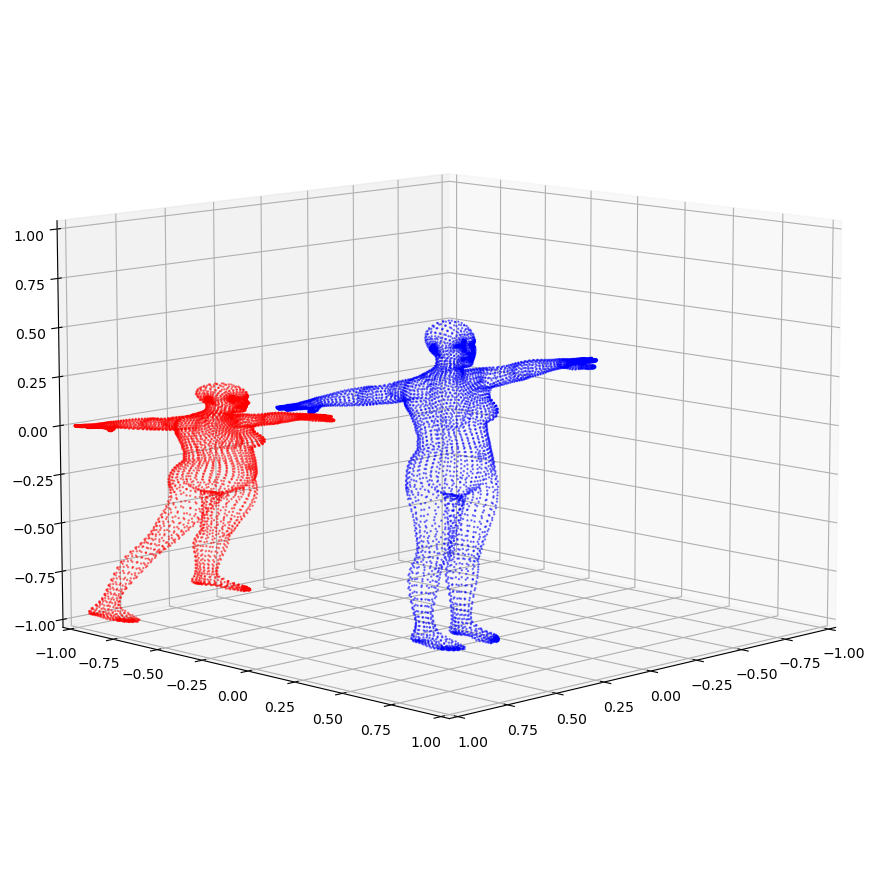

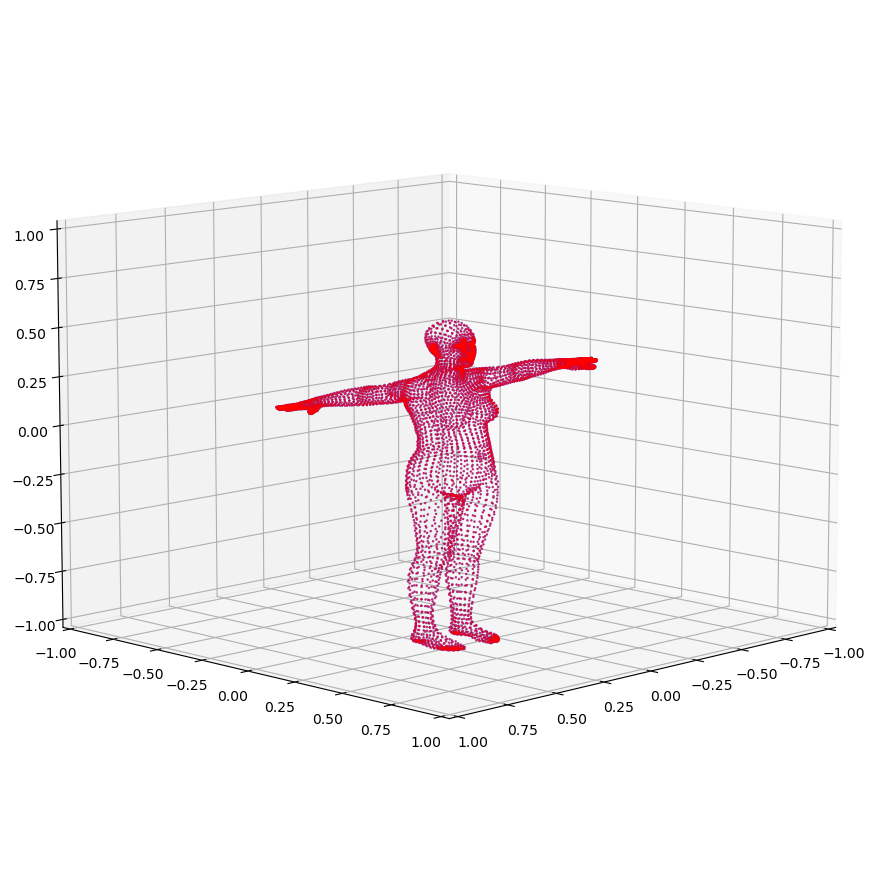

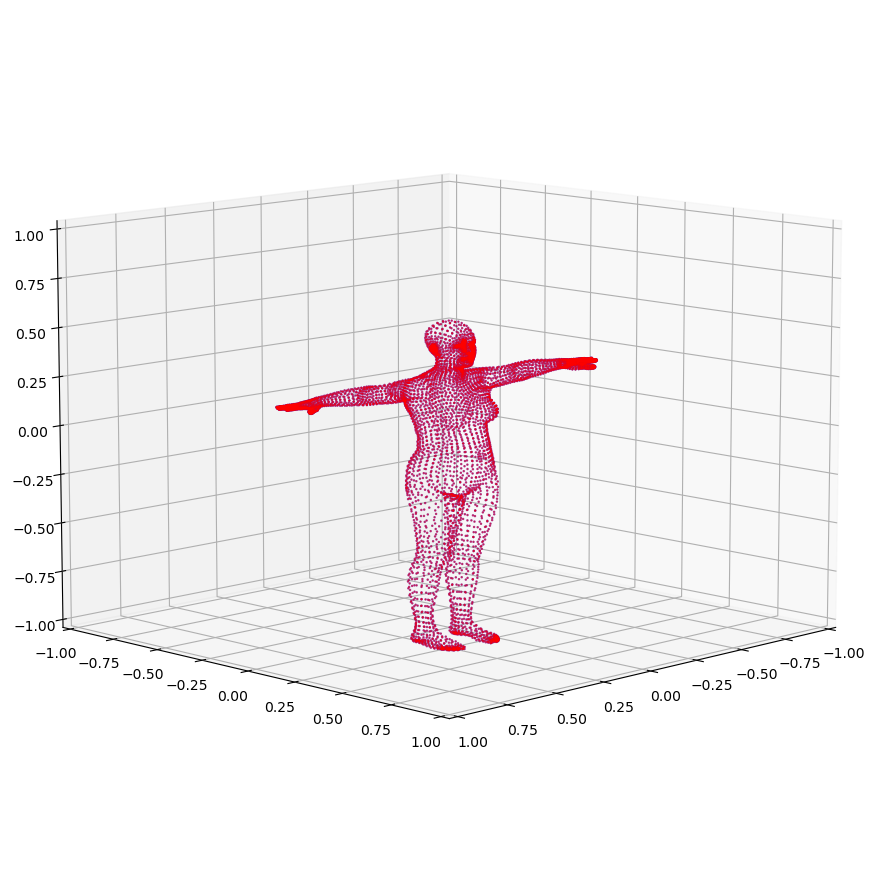

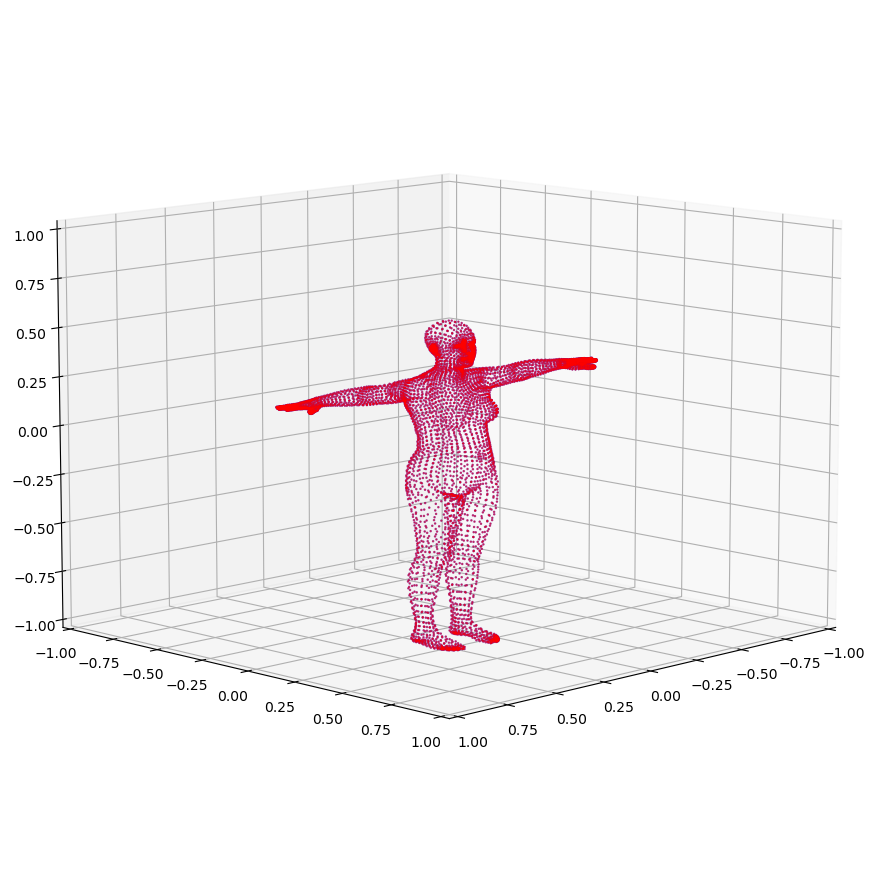

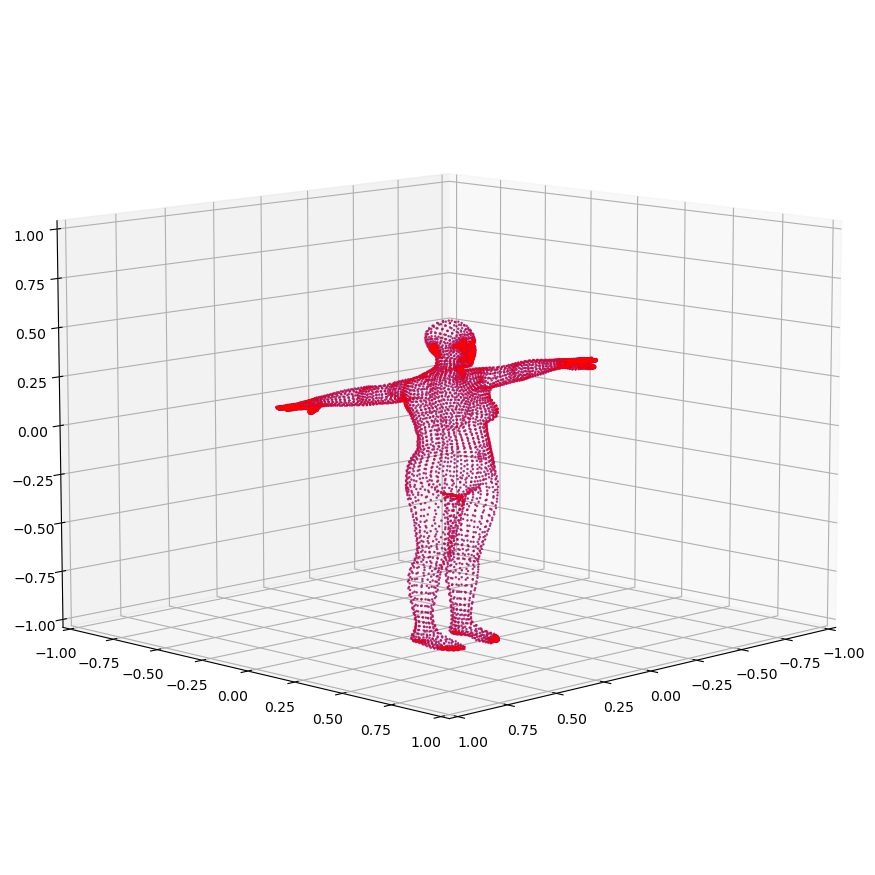

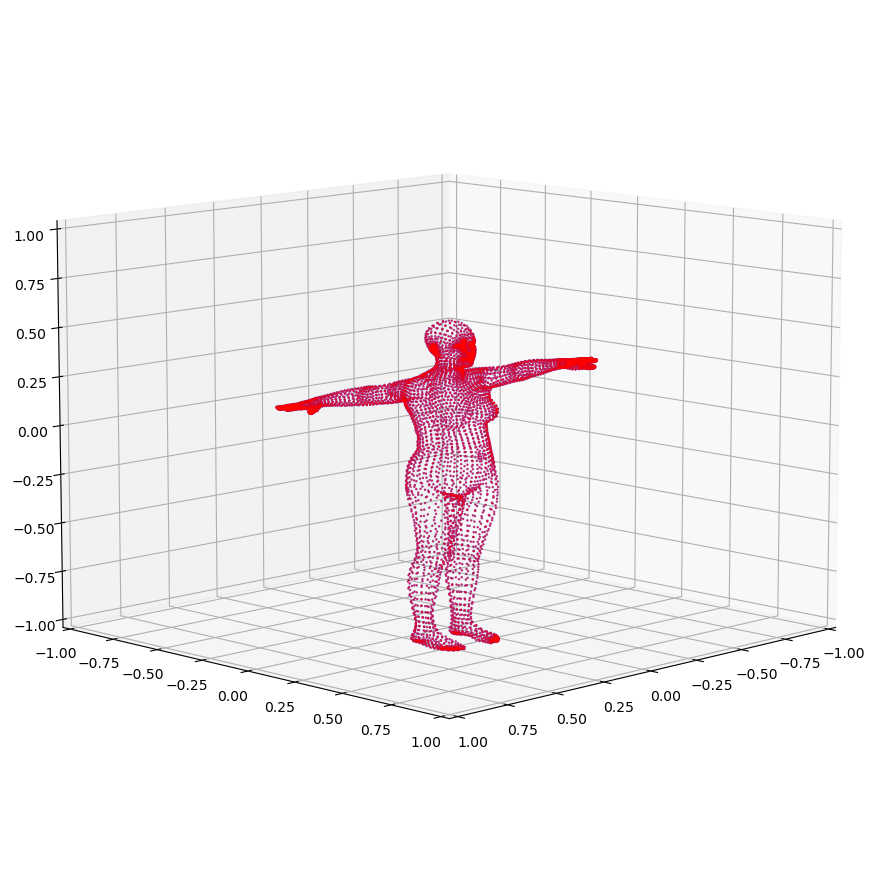

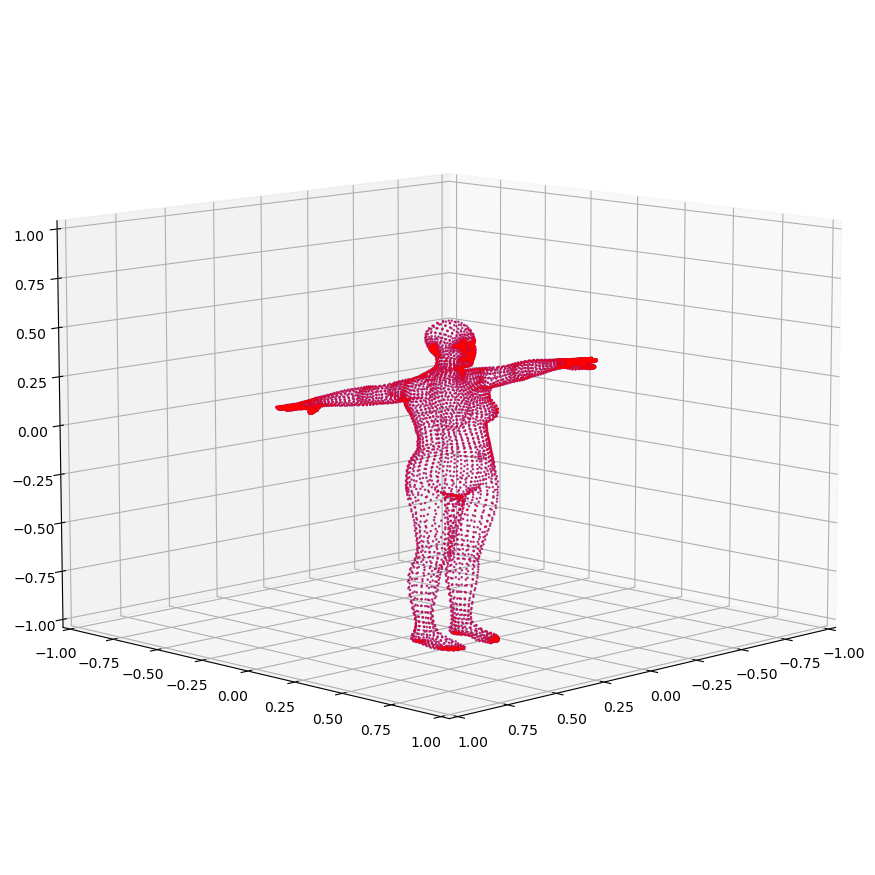

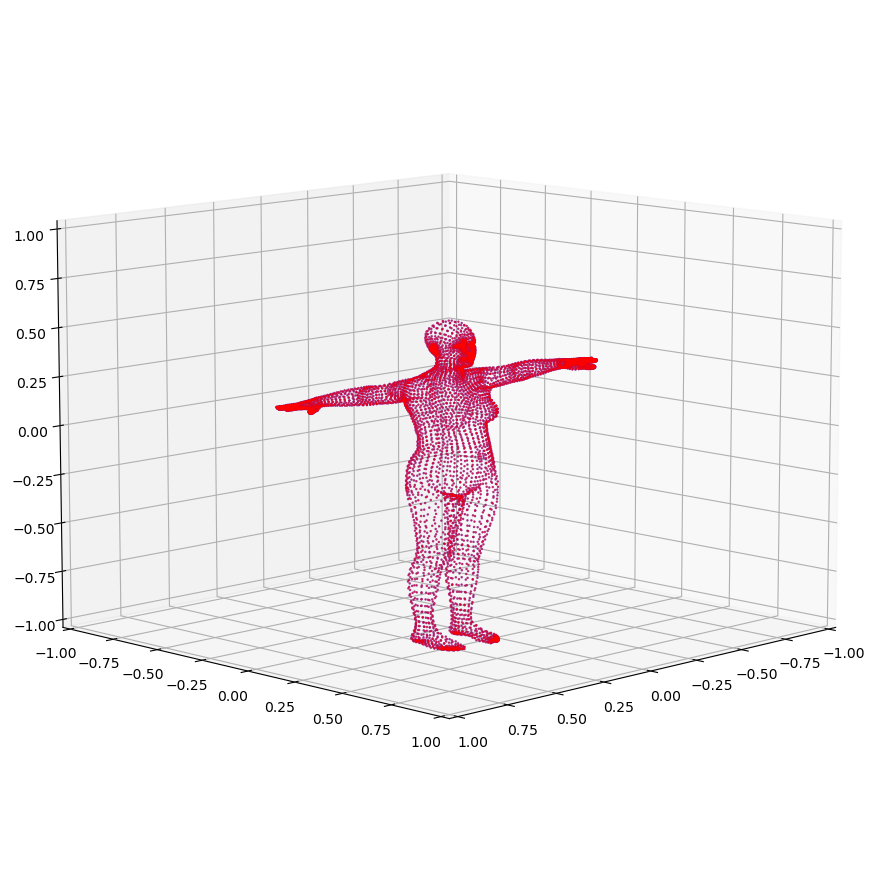

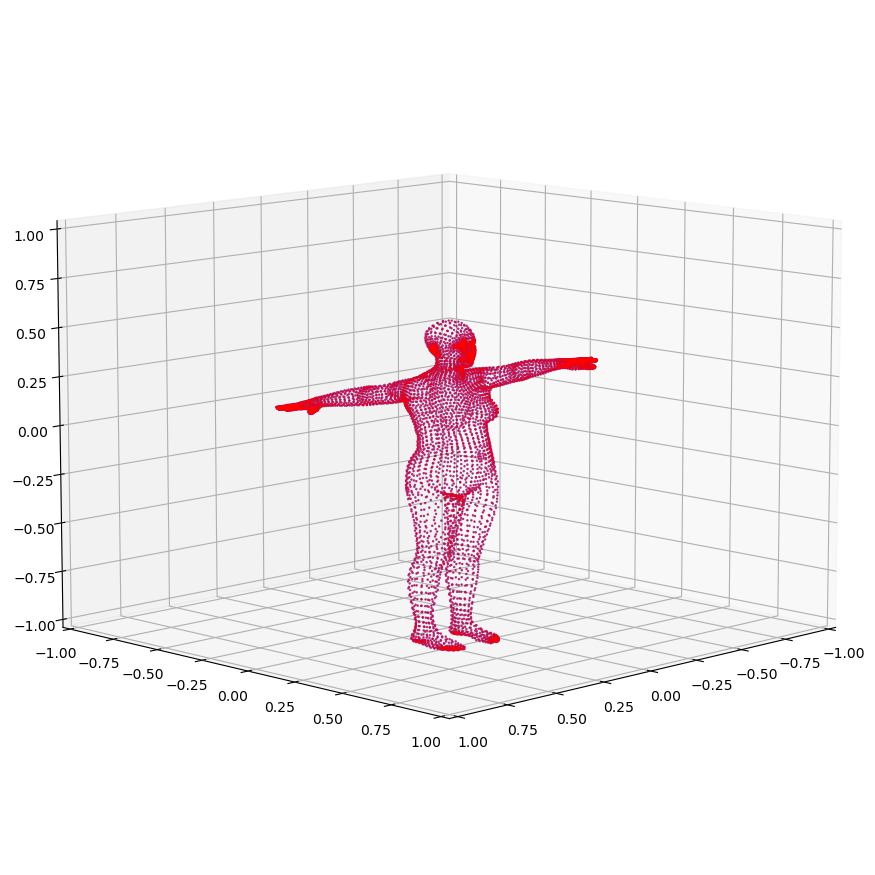

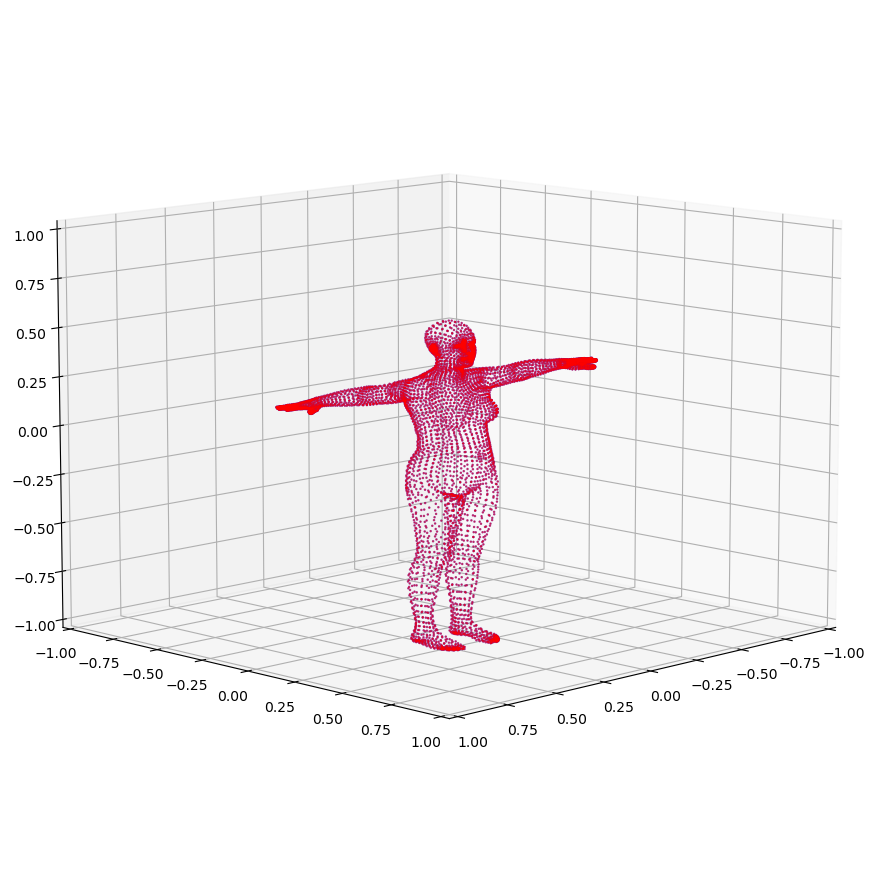

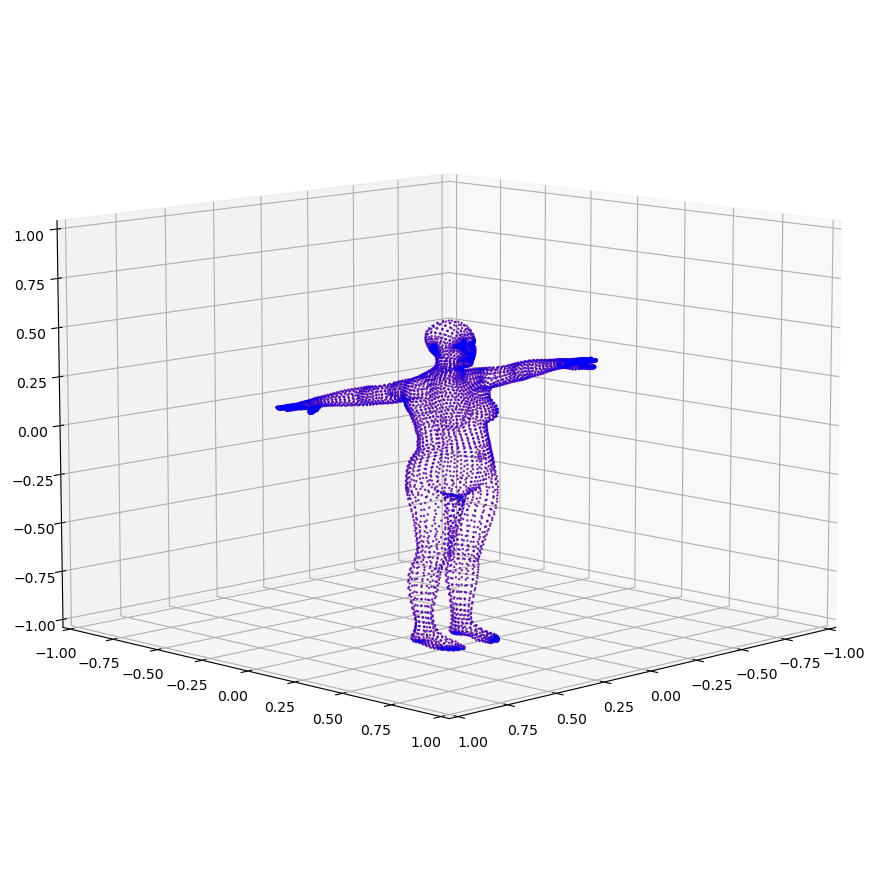

In [16]:
# TPS method
# our method 2: 
# input, X, Y, N0, n_projetions,
# output Yhat_list


data=torch.load('data/female_%d_%d.pt'%(i,j))
eta=0 # noise level
X0=data['X0']
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]
N0=X0.shape[0]




#@nb.njit()
def main_TPS(X,Y,N0,n_projections=300,eps=1e-4,recod_index=[0,10,20,30,40,60,80,90,100,150,200,250,300]):
    N1,D=X.shape
    C=X.copy()
    Phi0=kernel_matrix_TPS(C,X,D) 
    X_bar=np.hstack((np.ones((X.shape[0],1)),X))
    # initlize 
    R=np.eye(D)    
    S=1.0
    beta=np.zeros(3) #vec_mean(Y)-vec_mean(X.dot(S).dot(R)) 
    alpha=np.zeros((C.shape[0],D))
    B=np.vstack((beta,R))

    #paramlist=[]
    projections=random_projections(D,n_projections,1)
    mass_diff=0
    b=np.log((N1-N0+1)/1)
    Lambda=60*np.sum((Y.mean(0)-X.mean(0))**2)
    Y_hat=Phi0.dot(alpha)+X_bar.dot(B)
    # make_plot(Y_hat,Y)

    Domain_org=arange(0,N1)
    Delta=Lambda/8
    lower_bound=Lambda/10000
    L=Domain_org.copy()

    Yhat_list=list()
    for (epoch,theta) in enumerate(projections):
        # compute correspondence 
        Y_hat_theta=np.dot(theta,Y_hat.T)
        Y_theta=np.dot(theta,Y.T)

        Y_hat_indice,Y_indice=Y_hat_theta.argsort(),Y_theta.argsort()
        Y_hat_s,Y_s=Y_hat_theta[Y_hat_indice],Y_theta[Y_indice]
        obj,phi,psi,piRow,piCol=solve_opt(Y_hat_s,Y_s,Lambda)
        L=piRow.copy()
        L=recover_indice(Y_hat_indice,Y_indice,L)
        Domain=Domain_org[L>=0]

        #move selected Y_hat
        mass=Domain.shape[0]
        Range=L[L>=0]
        Y_hat[Domain]+=np.expand_dims(Y_theta[Domain]-Y_hat_theta[Domain],1)*theta

        # find optimal alpha, B
        Phi_T,X_bar_select,Y_select=Phi0[Domain],X_bar[Domain],Y_hat[Domain]
        alpha,B=TPS_recover_parameter(Phi_T,X_bar_select,Y_select,eps)


        # update selected points 
        # our model
        Y_hat=Phi0.dot(alpha)+X_bar.dot(B)

        
        # update lambda 
        N=(N1-N0)*1/(1+b*(epoch/500))+N0
        mass_diff=mass-N
        if mass_diff>N*0.009:
            Lambda-=Delta 
        if mass_diff<-N*0.003:
            Lambda+=Delta
            Delta=Lambda*1/8
        if Lambda<Delta:
            Lambda=Delta
            Delta=Delta*1/2
        if Delta<lower_bound:
            Delta=lower_bound
        
        # recode point cloud in the process
        if epoch in recod_index or epoch==n_projections-1:
            Yhat_list.append(Y_hat)
            
        if epoch%5==0 and epoch<=40:
            make_plot(Y_hat,Y)
        elif epoch%100==0: 
            make_plot(Y_hat,Y)
            
        
    return Yhat_list,Phi0,alpha,B


        
Yhat_list=main_TPS(X,Y,N0)


In [ ]:
error_list=list()
for Yhat in Yhat_list:
    error=np.linalg.norm(Yhat[0:N0][etamutation]-Y[0:N0])
    error_list.append(error)
    